In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import stats
from scipy.integrate import odeint
from lmfit import minimize, Parameters, Parameter, report_fit
from pyenzyme import EnzymeMLDocument
import json

debug = False
addZero = False

In [2]:
path = 'Document_Measurements.omex'
# check for correct file path and file extension:
if os.path.isfile(path) and os.path.basename(path).lower().endswith('.omex'):
    enzmlDoc = EnzymeMLDocument.fromFile(path)
else:
    print('Incorrect file path.')

enzmlDoc.printDocument()

Pinto_Measurements
>>> Reactants
	ID: s0 	 Name: L-cysteine
	ID: s1 	 Name: sulfide
	ID: s2 	 Name: L-alanine
>>> Proteins
	ID: p0 	 Name: Cysteine Desulfurase
>>> Complexes
>>> Reactions
	ID: r0 	 Name: Cysteine desulfuration


In [3]:
# Educts:
s0_init_conc = []
#Products
s1_init_conc = []
s2_init_conc = []
measured_data = []
# Protein:
p0_init_conc = []

# time and units
measurement = enzmlDoc.getMeasurement("m0")
time = measurement.global_time
time_unit = measurement.global_time_unit
conc_unit = ''

# go through all measurements:
for measurement in enzmlDoc.measurement_dict.values():
    
    # get replicates with time course data:
    reactant = measurement.getReactant('s1')
    unitID = reactant._unit_id
    conc_unit = reactant.unit
    
    for replicate in reactant.replicates:
        
        # Protein:
        p0_init_conc.append(measurement.getProtein('p0').init_conc)
        
        # Educts:
        s0_init_conc.append(measurement.getReactant('s0').init_conc)
        
        # Product:
        s1_init_conc.append(measurement.getReactant('s1').init_conc)
        s2_init_conc.append(reactant.init_conc)
        measured_data.append(replicate.data)
        

measured_data = np.array(measured_data)
p0_init_conc = np.array(p0_init_conc)
s0_init_conc = np.array(s0_init_conc)
s1_init_conc = np.array(s1_init_conc)
s2_init_conc = np.array(s2_init_conc)
time = np.array(time)

In [4]:
if addZero:
    time = np.append([0.0],time)
    measured_data2 = []
    for i in range(s1_init_conc.shape[0]):
        tmp = np.append(s1_init_conc[i],measured_data[i])
        measured_data2.append(tmp)
    measured_data2 = np.array(measured_data2)
    if debug:
        print(measured_data2)
    measured_data = measured_data2

/var/folders/0f/gvqwxk9d46z_cz6w3zg6yn1m0000gn/T/ipykernel_20000/3419418876.py:2: DeprecatedWarning: getName is deprecated. Use the attribute `name instead` instead.
  reaction_name = enzmlDoc.getReaction('r0').getName()


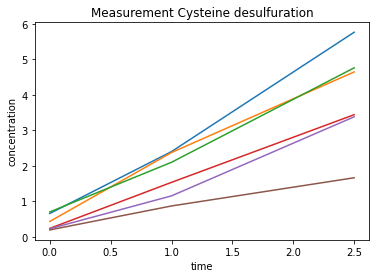

In [5]:
# plot time course data with matplotlib
reaction_name = enzmlDoc.getReaction('r0').getName()
plt.figure()
ax = plt.subplot()
for i in range(measured_data.shape[0]):
    ax.plot(time, measured_data[i, :], label='repl '+str(i+1))
plt.title('Measurement '+reaction_name)
ax.set_xlabel('time')
ax.set_ylabel('concentration')
plt.show()

In [6]:
def irreversible_Michaelis_Menten(w, t, params):
    '''
    Differential equation
    Arguments:
        w: vector of state variables: w = [S,E]
        t: time
        params: parameters object from lmfit
    '''
    
    S = w[0]
    E = w[1]
    
    kcat = params['k_cat'].value
    Km = params['K_M'].value
    bias = params['bias'].value
    
    # f(S', P', E'):
    dS = -kcat*E*(S-bias)/(Km+S-bias)
    dE = 0
    
    return (dS, dE)

def meten_with_substrat_dependent_enzymeinaktivation(w, t, params):
    '''
    Coupled differential equations
    Arguments:
        w: vector of state variables: w = [S,E]
        t: time
        params: parameters object from lmfit
    '''
    S = w[0]
    E = w[1]
    
    kcat = params['k_cat'].value
    Km = params['K_M'].value
    k_i = params['k_i'].value
    bias = params['bias'].value
    
    # f(S', E'):
    dS = -kcat*E*(S-bias)/(Km+S-bias)
    dE = -k_i*E*S
    
    return (dS, dE)

def meten_with_enzymeinaktivation(w, t, params):
    '''
    Coupled differential equations
    Arguments:
        w: vector of state variables: w = [S, E]
        t: time
        params: parameters object from lmfit
    '''
    S = w[0]
    E = w[1]
    
    kcat = params['k_cat'].value
    Km = params['K_M'].value
    k_i = params['k_i'].value
    bias = params['bias'].value
    
    # f(S', E'):
    dS = -kcat*E*(S-bias)/(Km+S-bias)
    dE = -k_i*E
    
    return (dS, dE)



In [7]:
def residual(params, t, data, w, f):
    '''
    Calculates residual between measured data and modeled data

    Args:
        params: parameters object from lmfit
        t: time
        data: measured data
        f: ODEs
    '''
    try:
        bias = np.array([params['bias'].value,0])
        w = np.add(w, bias)
    except KeyError:
        pass
    ndata = data.shape[0]
    residual = 0.0*data[:]
    for i in range(ndata):
        model = odeint(f, w[i], t, args=(params,))
        s_model = model[:,0]
        s0 = np.full(s_model.shape,w[i][0])
        residual[i,:]=s0 - measured_data[i,:]-s_model
    return residual.flatten()

In [8]:
colors = ['#f781bf','#984ea3','#ff7f00','#ffff33','#a65628','#4daf4a']

# Model 1a: irreversible Michaelis Menten

In [9]:
slopes = []
for i in range(measured_data.shape[0]):
    slope, intercept, r, p, se = stats.linregress(time, measured_data[i]) # time[0:2], data[i][0:2]
    slopes.append(slope)
vmax = np.max(slopes)
print(vmax)
E = p0_init_conc[0]
kcat = vmax/E
km = s0_init_conc[0]

w = np.append(s0_init_conc, p0_init_conc).reshape((2, s0_init_conc.shape[0]))
w = np.transpose(w)
if debug:
    print(w)

params = Parameters()
params.add('k_cat', value=kcat, min=0.0001, max=1000)
params.add('K_M', value=km, min=0.0001, max=np.max(measured_data)*100)
params.add('bias', value=0, vary=False)

2.0573406375789474


In [10]:
result_menten = minimize(residual , params, args=(time, measured_data, w, irreversible_Michaelis_Menten), method='leastsq')

In [11]:
report_fit(result_menten)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 18
    # variables        = 2
    chi-square         = 2.55326015
    reduced chi-square = 0.15957876
    Akaike info crit   = -31.1540131
    Bayesian info crit = -29.3732696
[[Variables]]
    k_cat:  2.22211219 +/- 0.11355104 (5.11%) (init = 2.057341)
    K_M:    8.53892410 +/- 2.06391179 (24.17%) (init = 500)
    bias:   0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_cat, K_M) = 0.697


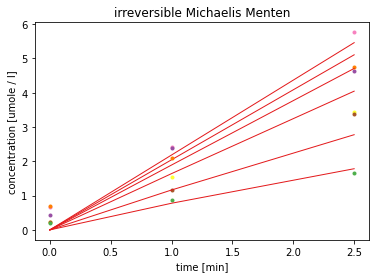

In [12]:
plt.figure()
ax = plt.subplot()
ax.clear()
for i in range(measured_data.shape[0]):
    s0 = np.full(measured_data[i].shape,w[i][0])
    data_fitted1a = odeint(irreversible_Michaelis_Menten, w[i], time, args=(result_menten.params,))
    ax.plot(time, measured_data[i, :], 'o', ms=3, label='repl '+str(i+1), color=colors[i])
    ax.plot(time, (s0-data_fitted1a[:,0]), '-', linewidth=1, color='#e31a1c', label='fitted data')
plt.title('irreversible Michaelis Menten')
xlabel = f"{'time'} [{time_unit}]"
ylabel = f"{'concentration'} [{conc_unit}]"
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)
plt.show()
if debug:
    print(w)